In [1]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("Matplotlib")
sc.install_pypi_package("s3fs")
sc.install_pypi_package("fuzzywuzzy")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1597064053054_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
from pyspark.sql.functions import *
from pyspark.sql.types import LongType

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Import Reference Tables

In [3]:
hcpcs="s3://ms-syntheamass-1m-mldata/syntheamassCSV/HCPCS/HCPCSCodescsv"
cvx = "s3://ms-syntheamass-1m-mldata/syntheamassCSV/CVX/web_cvx.csv"
loinc= "s3://ms-syntheamass-1m-mldata/syntheamassCSV/LOINC/Loinc.csv"
snomed= "s3://ms-syntheamass-1m-mldata/syntheamassCSV/SnomedCT_USEditionRF2_PRODUCTION_20200301T120000Z/snowmed.csv"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Input User Defined Variables Here:

In [4]:
bucket_data= "s3://ms-syntheamass-1m-mldata/syntheamassCSV/output_1/csv/observations.csv"##Choose the data set to review
K=8 ##Choose Number of Clusters
tabr = spark.read.format("csv").option("inferSchema", False).option("header", True).load(loinc)##Choose Reference Table

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# DataFrame

In [5]:
cdf = spark.read.format("csv").option("inferSchema",False).option("header",True).load(bucket_data)
cdf=cdf.select("CODE","DESCRIPTION")
cdf=cdf.dropna()
cdf.show(5,truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------------+
|CODE   |DESCRIPTION    |
+-------+---------------+
|8302-2 |Body Height    |
|8302-2 |Body Height    |
|29463-7|Body Weight    |
|29463-7|Body Weight    |
|39156-5|Body Mass Index|
+-------+---------------+
only showing top 5 rows

## Indexing Descriptions

In [6]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol="DESCRIPTION",outputCol="DESCRIPTION_I")
coord=indexer.fit(cdf).transform(cdf)
coord=coord.select("CODE","DESCRIPTION_I")
coord.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+
|   CODE|DESCRIPTION_I|
+-------+-------------+
| 8302-2|          0.0|
| 8302-2|          0.0|
|29463-7|          2.0|
|29463-7|          2.0|
|39156-5|          4.0|
+-------+-------------+
only showing top 5 rows

### Formats Code to Int

In [7]:
coord=coord.withColumn('CODE',regexp_replace('CODE','-',''))
if coord.dtypes[0][1]!='bigint':
    coord=coord.withColumn('CODE',col('CODE').cast(LongType()))
coord.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------------+
|  CODE|DESCRIPTION_I|
+------+-------------+
| 83022|          0.0|
| 83022|          0.0|
|294637|          2.0|
|294637|          2.0|
|391565|          4.0|
+------+-------------+
only showing top 5 rows

In [8]:
vis=coord.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

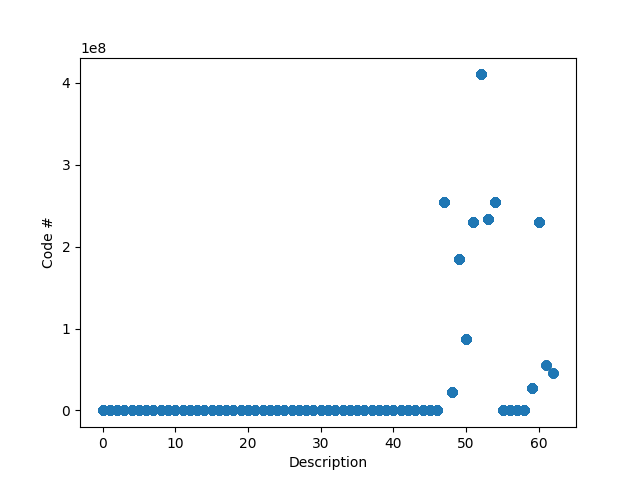

In [9]:
plt.scatter(vis['DESCRIPTION_I'],vis['CODE'])
plt.xlabel('Description')
plt.ylabel('Code #')
plt.show()
%matplot plt

## Clustering

### Making Feature Vectors

In [10]:
from pyspark.ml.feature import VectorAssembler
features = ["CODE","DESCRIPTION_I"]
assembler=VectorAssembler(inputCols=features,outputCol="features")
raw_data=assembler.transform(coord)
raw_data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------------+--------------+
|  CODE|DESCRIPTION_I|      features|
+------+-------------+--------------+
| 83022|          0.0| [83022.0,0.0]|
| 83022|          0.0| [83022.0,0.0]|
|294637|          2.0|[294637.0,2.0]|
|294637|          2.0|[294637.0,2.0]|
|391565|          4.0|[391565.0,4.0]|
+------+-------------+--------------+
only showing top 5 rows

In [11]:
from pyspark.ml.feature import StandardScaler
standardScaler=StandardScaler().setInputCol("features").setOutputCol("scaled_features")
raw_data=standardScaler.fit(raw_data).transform(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
raw_data.show(5,truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------------+--------------+------------------------------------------+
|CODE  |DESCRIPTION_I|features      |scaled_features                           |
+------+-------------+--------------+------------------------------------------+
|83022 |0.0          |[83022.0,0.0] |[0.008154233609368153,0.0]                |
|83022 |0.0          |[83022.0,0.0] |[0.008154233609368153,0.0]                |
|294637|2.0          |[294637.0,2.0]|[0.028938581676705027,0.26943809639674526]|
|294637|2.0          |[294637.0,2.0]|[0.028938581676705027,0.26943809639674526]|
|391565|4.0          |[391565.0,4.0]|[0.03845863124535956,0.5388761927934905]  |
+------+-------------+--------------+------------------------------------------+
only showing top 5 rows

## K-Means

In [13]:
from pyspark.ml.clustering import KMeans
kmeans=KMeans(featuresCol="scaled_features").setK(K)
model=kmeans.fit(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
predictions = model.transform(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
clusters=predictions.select("prediction")
clusters.groupby("prediction").agg({'prediction':'count'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|             6533|
|         6|           702248|
|         3|            90759|
|         4|          2872837|
|         5|             2019|
|         2|           285806|
|         7|           790620|
|         0|           632496|
+----------+-----------------+

## Bisecting K-Means

In [16]:
from pyspark.ml.clustering import BisectingKMeans
bkm=BisectingKMeans(featuresCol="scaled_features").setK(K)
model=bkm.fit(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
predictions_b=model.transform(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
cm=predictions_b.select("prediction")
cm.groupby("prediction").agg({'prediction':'count'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|          1177312|
|         6|             4116|
|         3|           632496|
|         4|          1437374|
|         5|           115811|
|         2|           834461|
|         7|             4436|
|         0|          1177312|
+----------+-----------------+

## Gaussian Mixture

In [19]:
from pyspark.ml.clustering import GaussianMixture
gm=GaussianMixture(featuresCol="scaled_features").setK(K)
model=gm.fit(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
predictions_c=model.transform(raw_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
cluster2=predictions_c.select("prediction")
cluster2.groupby("prediction").agg({'prediction':'count'}).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|          1106869|
|         6|           158124|
|         3|            16199|
|         4|           663073|
|         5|           474372|
|         2|          1040589|
|         7|           158124|
|         0|          1765968|
+----------+-----------------+

## Silhouette Score

In [22]:
from pyspark.ml.evaluation import ClusteringEvaluator
eVal=ClusteringEvaluator()
silhouette_k=eVal.evaluate(predictions)
silhouette_h=eVal.evaluate(predictions_b)
silhouette_g=eVal.evaluate(predictions_c)
print(f"""K = {str(K)} \n
K-Means = {str(silhouette_k)} \n
Bisecting K-Means = {str(silhouette_h)} \n
Gaussian Mixture = {str(silhouette_g)} """)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

K = 8 

K-Means = -0.407181659436687 

Bisecting K-Means = -0.22482571328181142 

Gaussian Mixture = 0.40599123339499343

# Visualization

In [23]:
cdf= cdf.toPandas()
kclust=clusters.toPandas()
hclust=cm.toPandas()
gclust=cluster2.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
clust=gclust #change *clust to look at different algorithmns
graph=pd.concat([vis,clust],axis=1)
text= pd.concat([cdf,clust],axis=1)
graph.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     CODE  DESCRIPTION_I  prediction
0   83022            0.0           0
1   83022            0.0           0
2  294637            2.0           1
3  294637            2.0           1
4  391565            4.0           1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

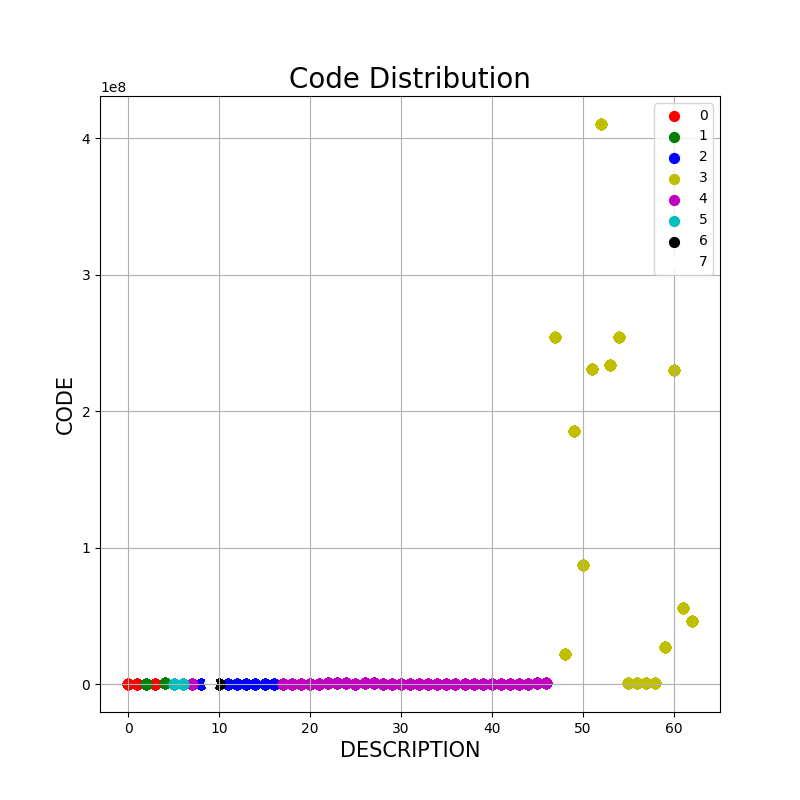

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('DESCRIPTION', fontsize = 15)
ax.set_ylabel('CODE', fontsize = 15)
ax.set_title('Code Distribution', fontsize = 20)


targets = [0,1,2,3,4,5,6,7,8]
colors = ['r', 'g', 'b','y','m','c','k','w']
for target, color in zip(targets,colors):
    indicesToKeep = graph['prediction'] == target
    ax.scatter(graph.loc[indicesToKeep, 'DESCRIPTION_I']
               , graph.loc[indicesToKeep, 'CODE']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
%matplot plt

# Analyzing Data

### Counts Length of each cluster, converts pd back to spark

In [26]:
group=text
total=coord.count()
g={}
c={}
sg={}
for i in range(K):
    g["group{0}".format(i)]=text[text['prediction']==i]
    c["count{0}".format(i)]=len(g["group{0}".format(i)])
    g["group{0}".format(i)]=spark.createDataFrame(g["group{0}".format(i)]).select("CODE","DESCRIPTION")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Makes Dictionary of at risk groups

In [27]:
alv=0;
r={}
for j in range(K):
    if c["count{0}".format(j)] < (total/K):
        r["risk{0}".format(alv)]=g["group{0}".format(j)]
        alv=alv+1
print("Number of at risk groups: ",alv)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of at risk groups:  5

### Merges At risk data

In [28]:
risk = r["risk0"]
for d in range(alv-1):
    risk=risk.union(r["risk{0}".format(d+1)])
risk.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1469892

## Code Analysis

### Look At Code Reference Table

In [29]:
tabr.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+--------+----------+------+---------+----------+--------+------------------+---------+---------------------+------+-------------+---------+-------+-------+-------------+-----------------+----------------+-------------+---------------+--------------------+----------------+-----------+------------------+---------------------+-------------------------+-------------+--------------------+-------------+------------------+---------------------+-------------+-----------+--------------------+----------------+-----------------+-------------------+------------------------+-----------------------+---------+---------------+----------------------+--------------------+-------------------------+-----------+
|LOINC_NUM|           COMPONENT|PROPERTY|TIME_ASPCT|SYSTEM|SCALE_TYP|METHOD_TYP|   CLASS|VersionLastChanged|CHNG_TYPE|DefinitionDescription|STATUS|CONSUMER_NAME|CLASSTYPE|FORMULA|SPECIES|EXMPL_ANSWERS|SURVEY_QUEST_TEXT|SURVEY_QUEST_SRC|UNITSREQUIRED|SUBMITTED_UNITS| 

### Set up table specific variables (write in name of code and description columns here)

In [37]:
tcode="`LOINC_NUM`"
tdesc="`LONG_COMMON_NAME`"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Match By Code

In [38]:
tabr.createOrReplaceTempView("tabr")

risk.createOrReplaceTempView("risk")

ma=spark.sql(f"""
select t.{tcode}, t.{tdesc},
r.DESCRIPTION, r.CODE 
from tabr t 
join risk r
on r.CODE = t.{tcode}
group by 1, 2, 3, 4""")
ma.show(truncate = True)
print("# of Matches: ",ma.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+--------------------+-------+
|LOINC_NUM|    LONG_COMMON_NAME|         DESCRIPTION|   CODE|
+---------+--------------------+--------------------+-------+
|   6206-7|Peanut IgE Ab [Un...|Peanut IgE Ab in ...| 6206-7|
|   4548-4|Hemoglobin A1c/He...|Hemoglobin A1c/He...| 4548-4|
|  33756-8|Polyp size greate...|Polyp size greate...|33756-8|
|   6106-9|Egg white IgE Ab ...|Egg white IgE Ab ...| 6106-9|
|  66519-0|Percentage area a...|Percentage area a...|66519-0|
|   8331-1|    Oral temperature|    Oral temperature| 8331-1|
|   6082-2|Codfish IgE Ab [U...|Codfish IgE Ab in...| 6082-2|
|   7258-7|Cow milk IgE Ab [...|Cow milk IgE Ab i...| 7258-7|
|   6833-8|Cat dander IgE Ab...|Cat dander IgE Ab...| 6833-8|
|  14959-1|Microalbumin/Crea...|Microalbumin Crea...|14959-1|
|  19926-5|            FEV1/FVC|           FEV1/​FVC|19926-5|
|  38265-5|DXA Radius and Ul...|DXA [T-score] Bon...|38265-5|
|  66529-9|Percentage area a...|Percentage area a...|66529-9|
|  57905

### Display codes without a match

In [39]:
tabr.createOrReplaceTempView("tabr")
risk.createOrReplaceTempView("risk")

spark.sql(f"""
select DISTINCT * 
from risk r
where r.CODE not in (select {tcode} from tabr)""").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|     CODE|         DESCRIPTION|
+---------+--------------------+
|254637007|Non-small cell lu...|
| 55680006|       Drug overdose|
| 26929004|Alzheimer's disea...|
| 22298006|Myocardial Infarc...|
|185086009|Chronic obstructi...|
|254632001|Small cell carcin...|
|410429000|      Cardiac Arrest|
|233604007|           Pneumonia|
|230265002|Familial Alzheime...|
| 46177005|End stage renal d...|
| 87433001|Pulmonary emphyse...|
|230690007|              Stroke|
+---------+--------------------+

In [40]:
risk.createOrReplaceTempView("risk")

spark.sql(""" select * from risk where CODE is null """).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----------+
|CODE|DESCRIPTION|
+----+-----------+
+----+-----------+

## Description Analysis

### Compare Entries

In [41]:
tabr.createOrReplaceTempView("tabr")
risk.createOrReplaceTempView("risk")

spark.sql(f"""
select t.{tdesc},
r.DESCRIPTION
from tabr t
join risk r
on t.{tcode} = r.CODE
group by 1, 2""").show(truncate = True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|    LONG_COMMON_NAME|         DESCRIPTION|
+--------------------+--------------------+
|Codfish IgE Ab [U...|Codfish IgE Ab in...|
|Egg white IgE Ab ...|Egg white IgE Ab ...|
|Common Ragweed Ig...|Common Ragweed Ig...|
|Cat dander IgE Ab...|Cat dander IgE Ab...|
|Soybean IgE Ab [U...|Soybean IgE Ab in...|
|    Oral temperature|    Oral temperature|
|Glomerular filtra...|Estimated Glomeru...|
|          HIV status|          HIV status|
|Wheat IgE Ab [Uni...|Wheat IgE Ab in S...|
|Creatinine [Mass/...|          Creatinine|
|Honey bee IgE Ab ...|Honey bee IgE Ab ...|
|Carbon dioxide, t...|      Carbon Dioxide|
|Calcium [Mass/vol...|             Calcium|
|Percentage area a...|Percentage area a...|
|History of Hospit...|History of Hospit...|
|      Housing status|      Housing status|
|DXA Radius and Ul...|DXA [T-score] Bon...|
|            FEV1/FVC|           FEV1/​FVC|
|Percentage area a...|Percentage area a...|
|Cow milk IgE Ab [...|Cow milk I

### Perform Natural Language Processing

In [42]:
from fuzzywuzzy import fuzz
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
tabr.createOrReplaceTempView("tabr")
risk.createOrReplaceTempView("risk")
descriptions = spark.sql(f"""
select t.{tdesc} as ref_description,
r.DESCRIPTION
from tabr t 
join risk r
on t.{tcode} = r.CODE
group by 1, 2""")

ratio = udf(fuzz.ratio)
partial_ratio = udf(fuzz.partial_ratio)
token_sort_ratio = udf(fuzz.token_sort_ratio)
token_set_ratio = udf(fuzz.token_set_ratio)

descriptions = descriptions.withColumn("ratio", 
                                       ratio(descriptions.ref_description, descriptions.DESCRIPTION))

descriptions = descriptions.withColumn("partial_ratio", 
                                       partial_ratio(descriptions.ref_description, descriptions.DESCRIPTION))

descriptions = descriptions.withColumn("token_sort_ratio", 
                                       ratio(descriptions.ref_description, descriptions.DESCRIPTION))

descriptions = descriptions.withColumn("token_set_ratio", 
                                       token_set_ratio(descriptions.ref_description, descriptions.DESCRIPTION))

descriptions.select("ratio", "partial_ratio", "token_sort_ratio", "token_set_ratio").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------------+----------------+---------------+
|ratio|partial_ratio|token_sort_ratio|token_set_ratio|
+-----+-------------+----------------+---------------+
|   75|           70|              75|            100|
|   77|           72|              77|            100|
|   80|           77|              80|            100|
|   78|           73|              78|            100|
|   75|           70|              75|            100|
|  100|          100|             100|            100|
|   32|           67|              32|             84|
|  100|          100|             100|            100|
|   74|           67|              74|            100|
|   47|          100|              47|            100|
|   77|           72|              77|            100|
|   44|           93|              44|            100|
|   38|          100|              38|            100|
|   93|           98|              93|             94|
|   89|           98|              89|            100|
|  100|   

### Display entries that do not match

In [43]:
descriptions.createOrReplaceTempView("descriptions")

dnom=spark.sql("""
select ref_description, DESCRIPTION from descriptions
where token_set_ratio < 70""")
dnom.show(truncate=False)
print("# of Unmatched Descriptions: ",dnom.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------------------------------------+-----------------------------------+
|ref_description                                                    |DESCRIPTION                        |
+-------------------------------------------------------------------+-----------------------------------+
|Cholesterol in LDL [Mass/volume] in Serum or Plasma by Direct assay|Low Density Lipoprotein Cholesterol|
+-------------------------------------------------------------------+-----------------------------------+

# of Unmatched Descriptions:  1